# Computational Linear Algebra for Large Scale Problems - HW_PCA

| Student Name         | Student ID | Email                    |
|----------------------|------------|--------------------------|
| Federico Fortunati         | 328854     | s328854@studenti.polito.it |
| Mattia Ottoborgo | 323001     | s323001@studenti.polito.it |


# Introduction
The topic of this homework concerns the application of  Principal Component Analysis on the given dataset to perform a dimensionality reduction combined with K-Means for clustering. The ultimate goal is to identify the customer profiles in which customers can be categorised.

# Library Import and configurations for homework replication

In [1]:
#Import libraries
%matplotlib widget
import pandas as pd
from datetime import datetime
import numpy as np
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, LabelEncoder, FunctionTransformer
import matplotlib
from IPython.display import display
from matplotlib.lines import Line2D
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score,silhouette_samples
from sklearn.impute import SimpleImputer

# disable warnings
import warnings
warnings.filterwarnings('ignore')
import re #TODO: find out if we need it or no.

In [2]:
#Setting random state for reproducibility
rs = min(323001,328854) #since there are two students
np.random.seed(rs)
R = np.random.RandomState(rs)

# Exercise 1 (Loading and Preparing the Data)

In [3]:
#km = KMeans(random_state=rs) 
#1.1 Read csv file and import dataset in dataframe
df_tot=pd.read_csv('cla4lsp customers.csv',sep='\t')

## 1.2 Sample 2/3 of the dataset 

In [4]:
workdf=df_tot.sample(frac=2/3,random_state=rs)
#check if percentage matches
workdf.shape[0]/df_tot.shape[0]
#remove features that won't be used for analysis
workdf=workdf.drop(columns=["ID","Z_CostContact","Z_Revenue"])

## 1.4 Randomly remove one column among the spending habits or the purchasing habits

In [5]:
def random_column():
    features_removable=[
    "MntWines", "MntFruits",
    "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds",
    "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"
]
    R = np.random.RandomState(rs)
    random_index=R.randint(0,len(features_removable))
    return features_removable[random_index]
column_to_remove=random_column()
workdf=workdf.drop(columns=column_to_remove)

In [6]:
column_to_remove

'MntWines'

MntWines is the feature column that won't be considered for analysis.

## 1.5 Dataset cleaning from missing values

In [7]:
#check for missing values
workdf.isna().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 17
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64

Let's check if some categorical attribute has been enconded with some string such as 'Unknown' or 'N/A'

In [8]:
cat_col_to_check=[]
for column in workdf.columns:
    if pd.api.types.is_object_dtype(workdf[column]):
       cat_col_to_check.append(column)
#Let's check the unique values of these columns
for column in cat_col_to_check:
    print(column,workdf[column].unique()[:10])

Education ['Master' 'Graduation' 'Basic' 'PhD' '2n Cycle']
Marital_Status ['Married' 'Together' 'Single' 'Divorced' 'Alone' 'Widow' 'Absurd' 'YOLO']
Dt_Customer ['01-10-2012' '24-03-2013' '04-11-2013' '29-11-2013' '24-10-2013'
 '01-10-2013' '02-01-2013' '07-05-2013' '11-12-2012' '15-02-2014']


We have noticed that the only feature containing null values is 'Income', hence we proceeed with the elimination of the rows with missing data. We decided to remove these rows since we are not able to retrieve this information, and the fill with any values would pollute the dataset and degrade PCA performance

In [9]:
workdf = workdf.dropna(subset=['Income'])

In [10]:
#workdf=workdf[(workdf['Marital_Status']!='Absurd') & (workdf['Marital_Status']!='Alone') & (workdf['Marital_Status']!='YOLO')]

## Dataset Analysis
Before proceeding with the encoding and pre-processing of the dataset, let's have a look at the dataset to identify the distributions of data to gain some insight.

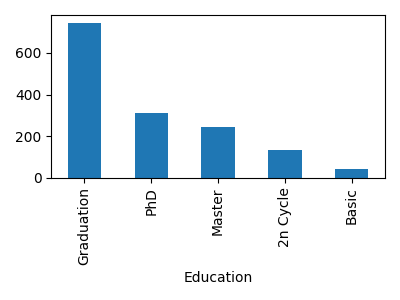

In [11]:
plt.figure()
workdf['Education'].value_counts().plot(kind='bar',figsize=(4,3))
plt.tight_layout()
#All the categorical attributes have a proper domain. We can proceed with the enconding of the categorical data.

In [12]:
workdf['Marital_Status'].value_counts()

Marital_Status
Married     581
Together    366
Single      317
Divorced    156
Widow        53
Alone         1
Absurd        1
YOLO          1
Name: count, dtype: int64

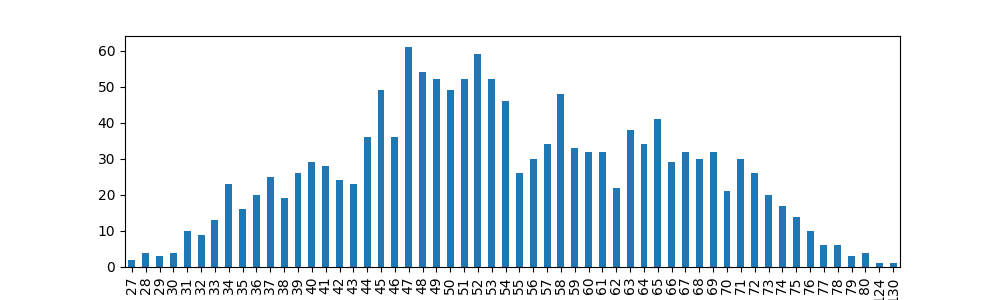

In [13]:
plt.figure()
workdf['Age']=2023-workdf['Year_Birth']
workdf['Age'].sort_values().value_counts().sort_index().plot(kind='bar',figsize=(10,3))
plt.show()

# Exercise 2 (Encoding of Categorical Data)
In this dataset, there are three categorical features: education, marital status and Dt_Customer. We decided to apply a One-Hot Encoder to Marital Status since we don't want to imply any order among the values that can be assumed by this feature. In addition, the domain is limited ( 9 unique values), so the dimensionality of the dataset will be increased of an acceptable factor. We decided to apply a Label Encoder to the Education feature since education levels can be ordered. We can now proceed with the implementation of the encoding phase for these two features:

In [14]:
#definition of encorders
enc_marital_status = OneHotEncoder(sparse=False)
enc_education = LabelEncoder()
#marital status encoding
enc_marital_status_df = pd.DataFrame(enc_marital_status.fit_transform(workdf[['Marital_Status']]),columns=enc_marital_status.categories_[0])
#workdf.reset_index(drop=True)
tmp_df=workdf.copy().reset_index(drop=True)
workdf=tmp_df.merge(enc_marital_status_df,left_index=True, right_index=True,how='left')
#workdf=workdf.merge(enc_marital_status_df,left_index=True, right_index=True,how='left')
#education encoding
workdf['Education_encoded']=enc_education.fit_transform(workdf['Education'])
#TODO: try to replicate mar status in one line like education.

For what concerns the Dt_customer feature, we decided to encoded it as the number of days passed from the first customer subscribed. 

In [15]:
#retrieve the first date in records.
date_ref=min([datetime.strptime(d, '%d-%m-%Y') for d in workdf['Dt_Customer']])

In [16]:
workdf['Dt_Customer'] = pd.to_datetime(workdf['Dt_Customer'],dayfirst=True)
workdf['days']= (workdf['Dt_Customer'] - date_ref).dt.days
#Remove labels columns and columns on which encoding has been applied
features_excluded=['Education','Marital_Status','Dt_Customer','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response','NumDealsPurchases','Recency','Year_Birth']

# Exercise 3 : (Preprocessing and full-PCA)
We can proceed now with the preprocessing. First, we create one copy of dataset keeping only the features we need. Then, we fit the Min-Max Scaler and the Standard Scaler on top of that and we transform the copy dataset by applying the transform method of each scaler, thus getting two copies of the original dataset.

In [17]:
#Create copy of original dataset
Xworkdf=workdf.drop(features_excluded,axis=1).copy()
#Create scalers
stdScaler=StandardScaler()
mmScaler=MinMaxScaler()
#Apply scalers
stdScaler.fit(Xworkdf.values)
mmScaler.fit(Xworkdf.values)
#Transform copy with two scalers.
Xwork_std=stdScaler.transform(Xworkdf.values)
Xwork_mm=mmScaler.transform(Xworkdf.values)
Xworkdf_std = pd.DataFrame(Xwork_std, columns=Xworkdf.columns)
Xworkdf_mm = pd.DataFrame(Xwork_mm, columns=Xworkdf.columns)

In [18]:
print("Variance Features Original dataset\n")
print(Xworkdf.var())
print("\nVariance Features after Standard Scaler\n")
print(Xworkdf_mm.var(axis=0))
print("\nVariance Features after Min-Max Scaler\n")
print(Xworkdf_mm.var(axis=0))
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#stdScaler.get_feature_names_out(Xworkdf.columns)

Variance Features Original dataset

Income                 7.215535e+08
Kidhome                2.919016e-01
Teenhome               2.961936e-01
MntFruits              1.614495e+03
MntMeatProducts        5.085349e+04
MntFishProducts        3.070736e+03
MntSweetProducts       1.675504e+03
MntGoldProds           2.587880e+03
NumWebPurchases        7.229305e+00
NumCatalogPurchases    8.807453e+00
NumStorePurchases      1.068880e+01
NumWebVisitsMonth      5.722017e+00
Age                    1.403876e+02
Absurd                 6.775068e-04
Alone                  6.775068e-04
Divorced               9.458454e-02
Married                2.388475e-01
Single                 1.687580e-01
Together               1.866060e-01
Widow                  3.464195e-02
YOLO                   6.775068e-04
Education_encoded      1.259703e+00
days                   4.065620e+04
dtype: float64

Variance Features after Standard Scaler

Income                 0.001635
Kidhome                0.072975
Teenhome       

Upon the analysis of the variance of the three dataframes, it emerges that:
- The variances of Xworkdf are on a different scale. For example Income is on the order of 10^8, whereas other fields are on the order of 1 or even 10^-1. This happens because each features has its own domain of values and no transformation is applied to deal with this aspect.
- The variances of Xworkdf_std are all equal to 1. This is due to the standardization applied with the Standard scaler.
- The variances of Xworkdf_mm are on a more similar magnitude than the ones in the original dataset, however they still present different values.u

This analysis anticipated us that employing Principal Component Analysis (PCA) on these datasets will yield distinct outcomes. PCA endeavors to minimize the number of components while maximizing explained variance, rendering it susceptible to features with greater variance. Consequently:
 - PCA applied to scaled data with Min-Max scaling will generate Principal Components less influenced by the magnitude discrepancies observed in the original dataset, yet more susceptible compared to the dataset scaled with the Standard Scaler.
 - PCA applied to the original dataset is expected to yield components strongly correlated with income, given its substantially higher variance.
 - PCA applied to scaled data with the Standard Scaler will produce Principal Components unaffected by variations in the magnitude of feature variances.

Next, we can apply the "full" PCA (which means, with no dimensionality reduction) to the three datasets.

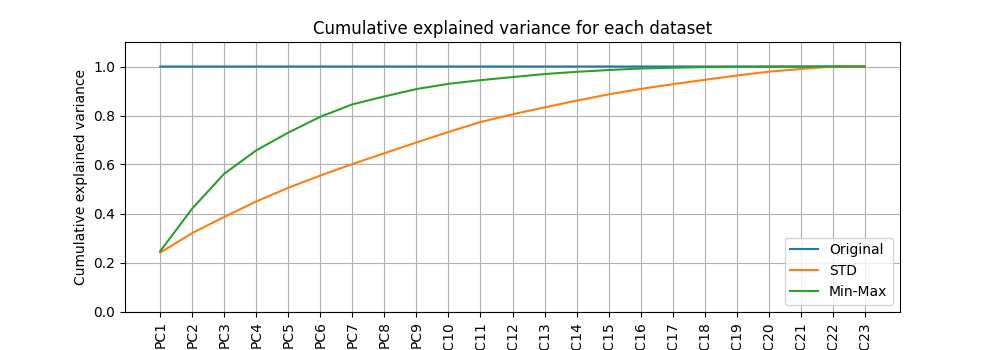

In [19]:
#Create PCA object for the datasets.

pca=PCA()
pca_std=PCA()
pca_mm=PCA()
#fit PCA to given dataset.
pca.fit(Xworkdf)
pca_std.fit(Xworkdf_std)
pca_mm.fit(Xworkdf_mm)
#Plot data
plt.figure(figsize=(10,3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_),label='Original')
#plt.title('NOstd')
plt.title('Cumulative explained variance for each dataset')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca.n_features_)],rotation='vertical')
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.plot(np.cumsum(pca_std.explained_variance_ratio_),label='STD')
plt.plot(np.cumsum(pca_mm.explained_variance_ratio_),label='Min-Max')
plt.legend()
plt.grid()
plt.show()

From the depicted plot, several observations appear evident:
- The PCA conducted on the original dataset explains over 99% of the total variance with a sole Principal Component.
- The PCA applied to Min-Max scaled data sexplains a major portion of cumulative variance in contrast to data subjected to transformation with the Standard Scaler.ncome.

This assert our previous observation: It is necessary to scale the data before applying PCA, otherwise we will get PCs strictly related to few components not because of their relevance, but rather beacuse of the greater variance hold by a specific domain, in this instance the income.

# Exercise 4 (Dimensionality Reduction and Interpretation of the PCs)

Next, we proceed with the dimensionality reduction: The assignment requires to choose number of components below 5 such that explains at least 33% of the total variance. Let's plot the percentage of total variance explained by each component for both the Standardized and Min-Max Scaled data:

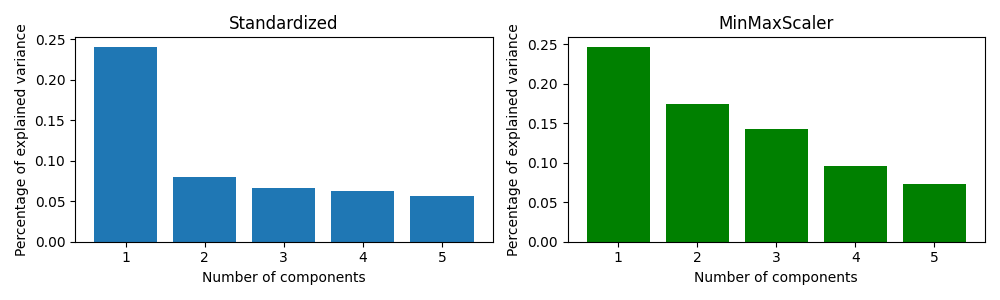

In [20]:
#Create figure for two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#Plot for Standardized data
ax[0].bar(np.arange(1, 6), pca_std.explained_variance_ratio_[:5])
ax[0].set_title('Standardized')
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Percentage of explained variance')
#Plot for Min-Max scaled data
ax[1].bar(np.arange(1, 6), pca_mm.explained_variance_ratio_[:5],color='green')
ax[1].set_title('MinMaxScaler')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Percentage of explained variance')
plt.tight_layout()
plt.show()

In [21]:
target_variance = 0.33
cumulative_variance = 0
num_components = 0
#Min-Max
cumulative_variance = np.cumsum(pca_mm.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"The minimum number of PCs required for Min-Max scaled data is: {min(5,num_components)}")
#Standardized
cumulative_variance = np.cumsum(pca_std.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"The minimum number of PCs required for standardized data is: {min(5,num_components)}")

The minimum number of PCs required for Min-Max scaled data is: 2
The minimum number of PCs required for standardized data is: 3


Based on the above snippet and barplot, it appears clear that the required amount of PCs to satisfy the requirements are respectively two for Min-Max scaled data and three for Standardized data.
Now that we have chosen the number of PCs to perform the dimensionality reduction, we can proceed with the fit and transformation of the data:

In [22]:
#number of PCs for dimensionality reduction.
m_mm=2
m_std=3
#Create PCA objects
pca_mm_m=PCA(n_components=m_mm)
pca_std_m=PCA(n_components=m_std)
#fit PCA
pca_mm_m.fit(Xworkdf_mm)
pca_std_m.fit(Xworkdf_std)
#apply dimensionality reduction on scaled data
Y_mm= pca_mm_m.transform(Xworkdf_mm)
Y_std=pca_std_m.transform(Xworkdf_std)


Next, we can iterate each PC and plot which features contribute to it. This will help us to give an interpretation to each Principal Component. Since the number of features is significant, we decide to filter and keep the most relevant features by checking which features have a contribute higher than  $\epsilon = \sqrt{1/n}$

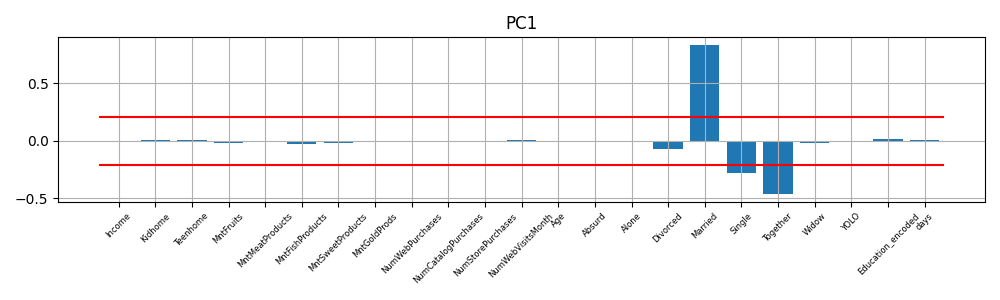


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Married']

HIGH-VALUED NEGATIVE COMPONENTS: ['Single', 'Together']
*********************************************



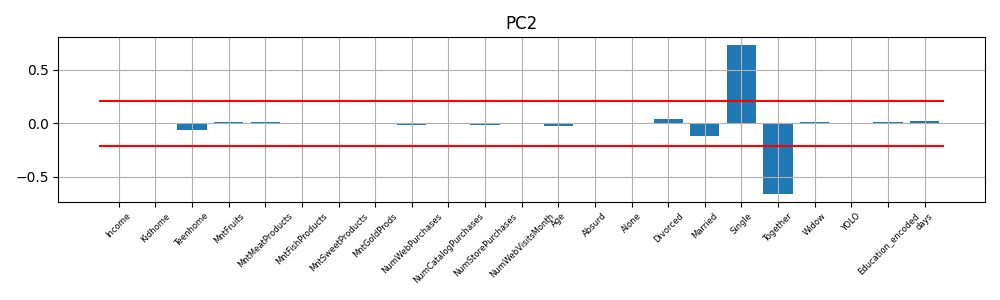


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Single']

HIGH-VALUED NEGATIVE COMPONENTS: ['Together']
*********************************************



In [23]:
features=Xworkdf.columns.to_list()
#Iteration of all PCs for PCA applied on Min-Max scaled data.
eps = np.sqrt(1/pca_mm_m.n_features_)
for ii in range(m_mm):
    # MAKE THE VARPLOT WITH SKILL TYPE COLORS
    plt.figure(figsize=(10, 3))
    plt.title(f"PC{ii + 1}")
    plt.bar(np.arange(pca_mm_m.n_features_),pca_mm_m.components_[ii,:])
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_mm_m.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_mm_m.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_mm_m.n_features_), 
               labels=features, 
               rotation=45,
               fontsize=6)
    plt.grid()
    plt.tight_layout()
    plt.show()
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii=np.argwhere(pca_mm_m.components_[ii,:]>= eps).flatten()
    ind_great_neg_PCii=np.argwhere(pca_mm_m.components_[ii,:]<= -eps).flatten()
    
    great_pos_PCii=[features[i] for i in ind_great_pos_PCii]
    great_neg_PCii=[features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}') 
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}') 
    print('*********************************************')
    print('')


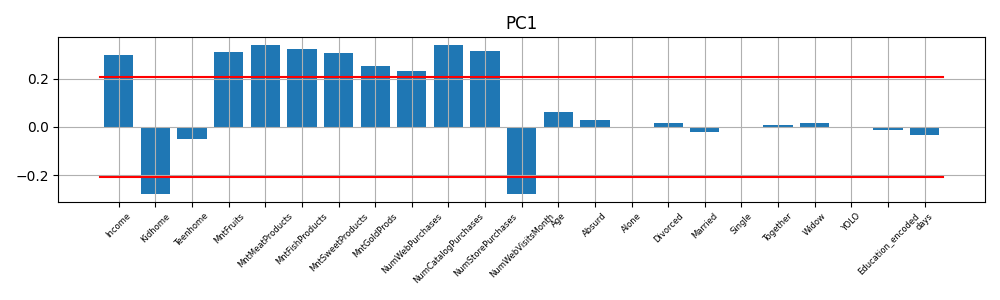


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Income', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

HIGH-VALUED NEGATIVE COMPONENTS: ['Kidhome', 'NumWebVisitsMonth']
*********************************************



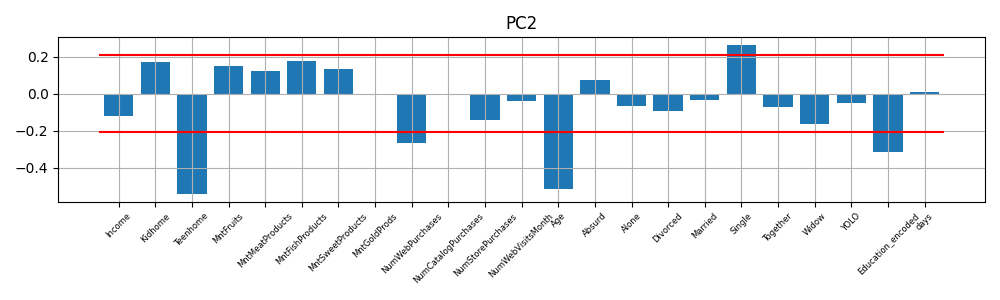


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Single']

HIGH-VALUED NEGATIVE COMPONENTS: ['Teenhome', 'NumWebPurchases', 'Age', 'Education_encoded']
*********************************************



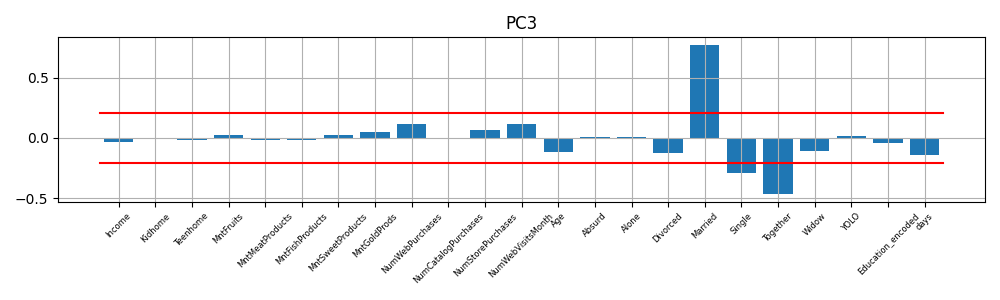


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Married']

HIGH-VALUED NEGATIVE COMPONENTS: ['Single', 'Together']
*********************************************



In [24]:
for ii in range(m_std):
    #Iteration of all PCs for PCA applied on Standardized  data.
    
    plt.figure(figsize=(10,3))
    plt.title(f"PC{ii + 1}")
    plt.bar(np.arange(pca_std_m.n_features_),pca_std_m.components_[ii,:])
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_std_m.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_std_m.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_std_m.n_features_), 
               labels=features, 
               rotation=45,
               fontsize=6)
    plt.grid()
    plt.tight_layout()
    plt.show()
    ind_great_pos_PCii=np.argwhere(pca_std_m.components_[ii,:]>= eps).flatten()
    ind_great_neg_PCii=np.argwhere(pca_std_m.components_[ii,:]<= -eps).flatten()
    
    great_pos_PCii=[features[i] for i in ind_great_pos_PCii]
    great_neg_PCii=[features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}') 
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}') 
    print('*********************************************')
    print('')

By observing the plot for each PC of Min-Max scaled data, we can deduce that:

- The first PC is positevly correlated with 'Married' and negatively correlated with 'Single' and 'Together'. We decide to interpret this PC as 'Married (+) vs  Single and Together (-)'. We interpreted this PC as the contrast between "official" relationships (e.g marriage) against single and couples. The difference between couples and married couples could be counter-intuitive, however by looking to the other components below the threshold, we can see that also 'Divorced' and 'Widow' are negatively correlated with this PC, thus we thought that this PC wants to distinguish customers in a marriage and customers that are not.
- The second PC is positively correlated with 'Single' and negatively correlated with 'Together'. We decided to interpret this PC as the contrast between customer in a relationship versus the ones not in a relationship, thus the name 'In relationship(+) vs Non relationship (-)'




By observing the plot for each PC of the standardized data, we have drawn the following conclusions:
- The first PC is positively correlated to 'Income', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases' and negatively correlated to 'Kidhome', 'NumWebVisitsMonth'. We interpreted this PC as a description of entities that tend to have high income and purchase a lot of products, without kids and not a lot of web visits. Thus, we defines this PC as 'Wealthy and Spendthrift (+) vs  no kids and no web visits (-)'
- The second PC is positively correlated with 'Single' and negatively correlated with  ['Teenhome', 'NumWebPurchases', 'Age', 'Education_encode. We interpreted this PC as discriminant between entities that are single, young, with low education and entities that are in relationship and higher age. Thus we called this PC 'Single, young, not advanced education (+) vs  Grown up in a relationship (-)'.
- The third PC is positively correlated with 'Married' and negatively correlated with 'Single' and 'Together'. As for the Min-Max Scaler, we defined this PC as  'Married (+) vs  Single and Together (-)'d'

In [25]:
pc_names_mm = ['Married (+) vs \n Single/Together (-)', 
           'In rel.(+) vs \n Non rel. (-)'
           ]
pc_names_std = ['Wealthy/Spendthrift (+) vs \n no kids/no web visits (-)', 
           'Single, young, not adv. edu. (+) vs \n Grown up in a rel. (-)',
            'Married (+) vs \n Single/Together (-)'
           ]

We can proceed with the plot of the scoregraph for both datasets:

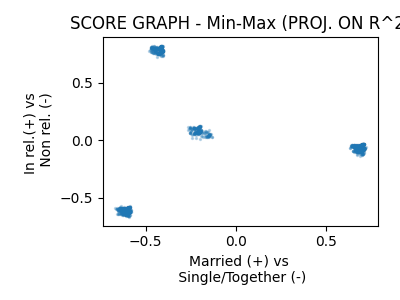

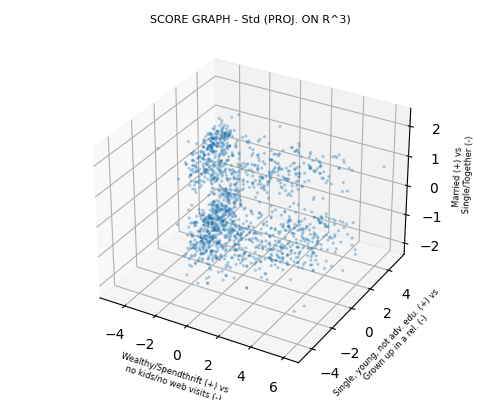

In [26]:
# transform data
Y_mm = pca_mm_m.transform(Xworkdf_mm)
Y_std = pca_std_m.transform(Xworkdf_std)
#Scoregraph Min-Max
plt.figure(figsize=(4,3))
plt.scatter(Y_mm[:,0],Y_mm[:,1],s=2,alpha=0.25) 
plt.title('SCORE GRAPH - Min-Max (PROJ. ON R^2)')
plt.xlabel(pc_names_mm[0])
plt.ylabel(pc_names_mm[1])
plt.tight_layout()
plt.show()

#Scoregraph standardization
sg_3d = plt.figure(figsize=(5,4))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
ax_sg_3d.scatter(Y_std[:,0],Y_std[:,1],Y_std[:,2],s=2,alpha=0.25)  
plt.title('SCORE GRAPH - Std (PROJ. ON R^3)',fontsize=8)
ax_sg_3d.set_xlabel(pc_names_std[0],fontsize=6)
ax_sg_3d.set_ylabel(pc_names_std[1],fontsize=6)
ax_sg_3d.set_zlabel(pc_names_std[2],fontsize=6)
plt.tight_layout()
plt.grid()
plt.show()

From the two plot depicted, we can evince that:
- The utilization of the Min-Max scaler facilitated the segmentation of our customers into four distinct clusters.
- Standardization, on the other hand, resulted in the formation of two, not well distincted clouds.
  These clouds exhibited higher density towards the positive axis of the PC 'Single, young, not advanced education (+) vs Grown up in a relationship (-)' and the negative axis of the PC ''Wealthy and Spendthrift (+) vs  no kids and no web visits (-)'

# Exercise 5 (k-Means)
We can now run the K-Means algorithm to cluster our data and profile our customers.

In [27]:

#Initialise lists to contain K-Means objects and silhouette scores during iteration to find the best K
#for the Min-Max Scaler.
km_list = []
silcoeff_list_mm = []
k_list = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list)):
    print(f'****************** START k-MEANS WITH k={k_list[i]} ******************')
    print('Computing...')
    km_list.append(KMeans(n_clusters=k_list[i],n_init=3, random_state=rs)) 
    km = km_list[i]
    km.fit(Y_mm)
    silcoeff_list_mm.append(silhouette_score(Y_mm, km.labels_)) 
    
    print(f'****************** END k-MEANS WITH k={k_list[i]}, sil_score={silcoeff_list_mm[i]} ******************')
    print('')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best = np.argmax(silcoeff_list_mm) 
k_mm = k_list[i_best]
km_mm = km_list[i_best]
# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_mm)} --> k = {k_mm}') 
print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3, sil_score=0.8482042462461241 ******************

****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4, sil_score=0.9539049749938856 ******************

****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5, sil_score=0.7747253208257092 ******************

****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6, sil_score=0.6594991038714525 ******************

****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7, sil_score=0.6011247210178845 ******************

****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8, sil_score=0.5008067691340001 ******************

****************

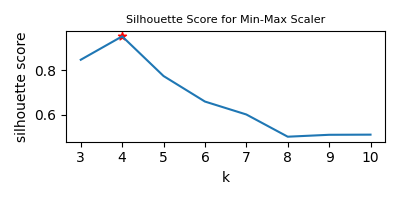

The optimal number of clusters is 4


In [28]:
plt.figure(figsize=(4, 2))
plt.title('Silhouette Score for Min-Max Scaler',fontsize=8)
plt.xlabel('k')
plt.ylabel('silhouette score')
# add vertical line for the optimal k
plt.scatter(k_mm, silcoeff_list_mm[i_best],
             marker='*', color='red')
plt.plot(k_list, silcoeff_list_mm)
plt.xticks(k_list)
plt.tight_layout()
plt.show()
print(f"The optimal number of clusters is {k_mm}")

In [29]:
km_list = []
silcoeff_list_std = []
k_list = list(range(3, 11))
for i in range(len(k_list)):
    print(f'****************** START k-MEANS WITH k={k_list[i]} ******************')
    print('Computing...')
    km_list.append(KMeans(n_clusters=k_list[i],n_init=9, random_state=rs)) 
    km = km_list[i]
    km.fit(Y_std)
    silcoeff_list_std.append(silhouette_score(Y_std, km.labels_))   
    print(f'****************** END k-MEANS WITH k={k_list[i]}, sil_score={silcoeff_list_std[i]} ******************')
    print('')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best = np.argmax(silcoeff_list_std) 
k_std = k_list[i_best]
km_std = km_list[i_best]
# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_std)} --> k = {k_std}') 
print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3, sil_score=0.3463538121736576 ******************

****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4, sil_score=0.3531172517417804 ******************

****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5, sil_score=0.36937992994358293 ******************

****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6, sil_score=0.35242602352119035 ******************

****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7, sil_score=0.3709447315401772 ******************

****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8, sil_score=0.35850436623436316 ******************

*************

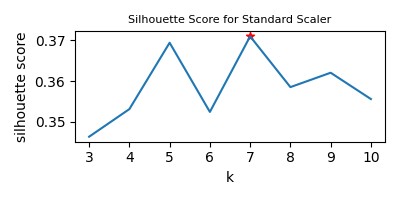

The optimal number of clusters is 7


In [30]:
plt.figure(figsize=(4, 2))
plt.title('Silhouette Score for Standard Scaler',fontsize=8)
plt.xlabel('k')
plt.ylabel('silhouette score')
# add vertical line for the optimal k
plt.scatter(k_std, silcoeff_list_std[i_best],
             marker='*', color='red')
plt.plot(k_list, silcoeff_list_std)
plt.xticks(k_list)
plt.tight_layout()
plt.show()
print(f"The optimal number of clusters is {k_std}")

From the previous code snippet and relative graph, we can deduce that the optimal k for the Min-Max scaler and the Standard scaler are respectively 4 and 7

# Exercise 6 (Clusters and Centroid Interpretation and Visualization)
Now that we obtained the optimal number of clusters for each cluster, we can proceed with the application of the actual K-Means algorithm. First, we map each label to a color for the following representations. Then we can proceed to represent each cluster

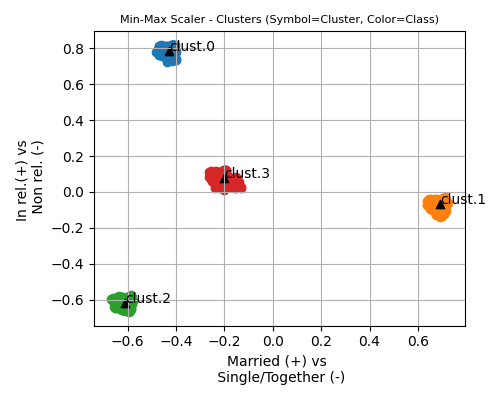

In [31]:
#Plot clusters for Min-Max
colors = cm.tab20.colors

plt.figure(figsize=(5,4))
#plot each cluster with different colours
for ll in np.unique(km_mm.labels_):
    plt.scatter(Y_mm[km_mm.labels_ == ll, 0], Y_mm[km_mm.labels_ == ll, 1])
#plot center of each cluster
for kk in range(k_mm):
    plt.text(km_mm.cluster_centers_[kk, 0], km_mm.cluster_centers_[kk, 1], f'clust.{kk}')
plt.scatter(km_mm.cluster_centers_[:, 0], km_mm.cluster_centers_[:, 1], c='black', marker='^')

plt.title('Min-Max Scaler - Clusters (Symbol=Cluster, Color=Class)',fontsize=8)
plt.xlabel(pc_names_mm[0])
plt.ylabel(pc_names_mm[1])
plt.tight_layout()
plt.grid()
plt.show()

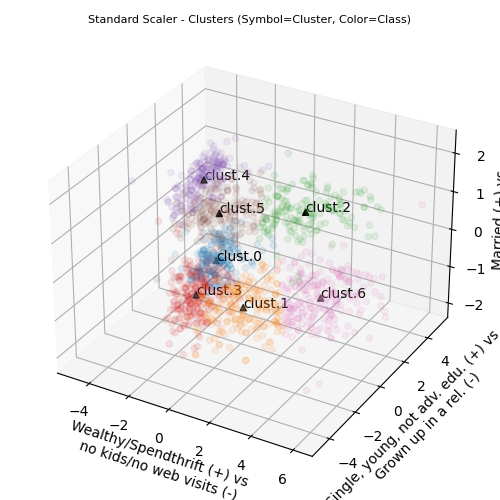

In [32]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
for ll in np.unique(km_std.labels_):
    ax.scatter(Y_std[km_std.labels_ == ll, 0], Y_std[km_std.labels_ == ll, 1], Y_std[km_std.labels_ == ll, 2],alpha= 0.1)
for kk in range(k_std):
    ax.text(km_std.cluster_centers_[kk, 0], km_std.cluster_centers_[kk, 1],km_std.cluster_centers_[kk, 2], f'clust.{kk}')
ax.scatter(km_std.cluster_centers_[:, 0], km_std.cluster_centers_[:, 1], km_std.cluster_centers_[:, 2], c='black', marker='^')
plt.title('Standard Scaler - Clusters (Symbol=Cluster, Color=Class)',fontsize=8)
ax.set_xlabel(pc_names_std[0])
ax.set_ylabel(pc_names_std[1])
ax.set_zlabel(pc_names_std[2])
plt.tight_layout()
plt.grid()
plt.show()

In order to better understand the combination of the PCs to determine the cluster center characteristics, we proceed with the following plots:

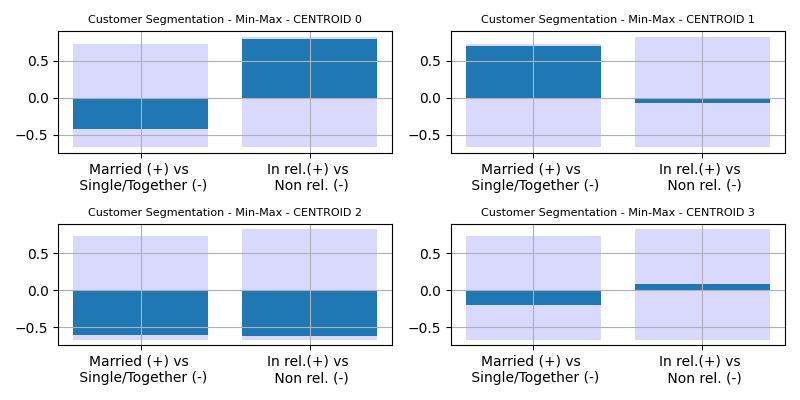

In [33]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Y_mm.max(axis=0)
mins_y = Y_mm.min(axis=0)

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(2, 2, figsize=(8, 4))
for ii in range(k_mm):
    ir = ii // 2
    ic = ii % 2
    ax_centroids[ir, ic].bar(np.arange(km_mm.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange(km_mm.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange(km_mm.cluster_centers_.shape[1]),km_mm.cluster_centers_[ii,:]) 
    ax_centroids[ir, ic].set_xticks(ticks=np.arange(km_mm.cluster_centers_.shape[1])) 
    ax_centroids[ir, ic].set_xticklabels(labels=pc_names_mm)  
    ax_centroids[ir, ic].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ir, ic].set_title(f"Customer Segmentation - Min-Max - CENTROID {ii}",fontsize=8)

Based on these barplot, we identified the following clusters:
- '0-Engaged', since they present a high positive component of relationship, but are not married.
- '1-Have been married (Widow / Divorced)' ,since they are married, but not in a relationship
- '2-Single', since they aren't married and not in a relationship.
- '3-Together', since it present a similar composition to the one in Engaged, but less marked.

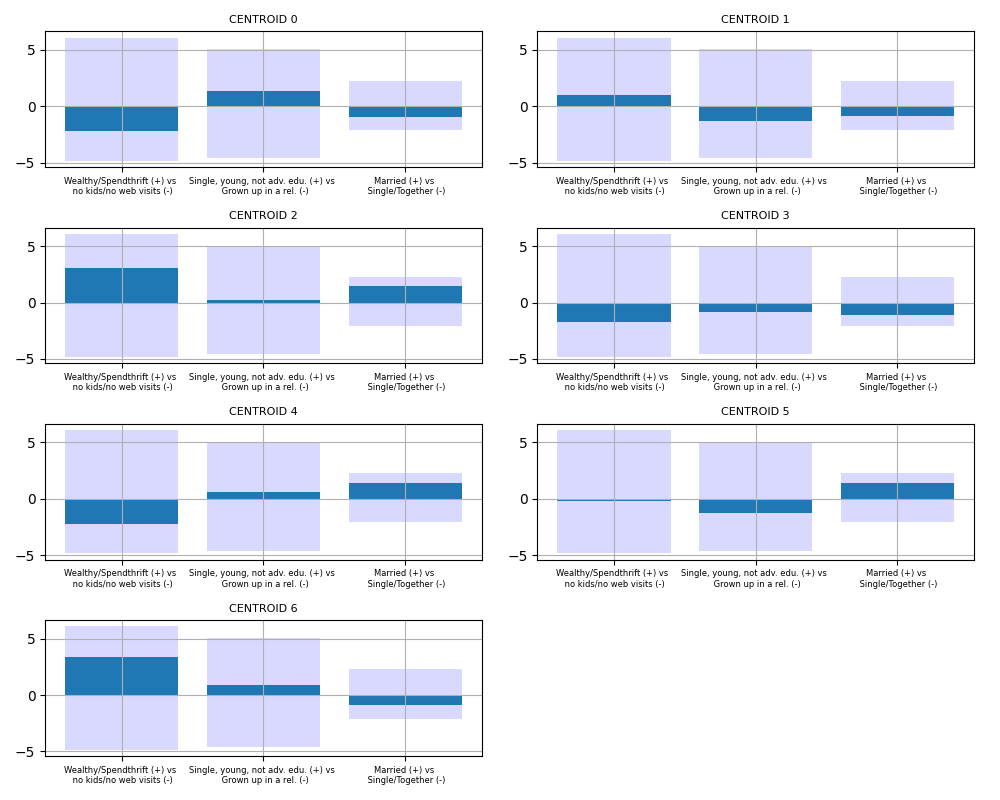

In [34]:

# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Y_std.max(axis=0)
mins_y = Y_std.min(axis=0)

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(4,2, figsize=(10,8))
for ii in range(k_std):
    ir = floor(ii / 2)
    ic = ii % 2
    ax_centroids[ir,ic].bar(np.arange(km_std.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ir,ic].bar(np.arange(km_std.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ir,ic].bar(np.arange(km_std.cluster_centers_.shape[1]), km_std.cluster_centers_[ii,:])  
    ax_centroids[ir,ic].set_xticks(ticks=np.arange(km_std.cluster_centers_.shape[1])) 
    ax_centroids[ir,ic].set_xticklabels(labels=pc_names_std,fontsize=6)  
    ax_centroids[ir,ic].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ir,ic].set_title(f'CENTROID {ii}',fontsize=8)
#remove empty figures
[fig_centroids.delaxes(ax) for ax in ax_centroids.flatten() if not ax.has_data()]
plt.show()

Based on these barplot, we identified the following clusters:
- '0-young single with no kids', since they have a negative component of PC1, which means they don't have kids, a positive component of PC2, which means, single and young, and a negative component of PC3, which means they are not married.
- '1-wealthy, middle age couple', since they have a positive component of PC1, a positive component of PC2, and a negative component of PC3
- '2-wealthy widow/divorced', since they have a highly positive component of PC1, a slightly positive component of PC2, and a positive component of PC3
- '3-early relationship', since they have a negative component of PC1, a slightly negative component of PC2, and a negative component of PC3
- '4-no kids married', since they have a negative component of PC1, a slightly positive component of PC2, and a positive component of PC3
- '5-middle age married couple', since they have a slightly negative component of PC1, a negative component of PC2, and a positive component of PC3
- '6-single, wealthy', since they have a really positive component of PC1, a positive component of PC2, and a negative component of PC3

In [35]:
cluster_names_mm = ['0-Engaged','1-Have been married (Widow / Divorced)','2-Single','3-Together']
cluster_names_std = ['0-young single with no kids','1-wealthy, middle age couple','2-wealthy widow/divorced','3-early relationship','4-no kids married','5-middle age married couple','6-single, wealthy']

# Exercise 7 - Clusters and Centroids Evaluation
Now that we have carried out both the PCA dimensionality reduction and the K-Means clustering, we can evaluate the quality of our clusters using both Internal and External evaluation

## Internal evaluation - Silhouette scores
The below script provides us a simple table to evaluate the silhouette scores of both scalers

In [36]:
print("Silhouette scores - Min-Max Scaler")
silscores=silhouette_samples(Y_mm,km_mm.labels_)
cluster_silscores=[np.mean(silscores[km_mm.labels_==kk]) for kk in range(k_mm)]
display(pd.DataFrame(np.array(cluster_silscores+[np.max(silcoeff_list_mm)]),index=cluster_names_mm+['Global'],columns=['Sil. Score']))

print("Silhouette scores - Standard Scaler")
silscores=silhouette_samples(Y_std,km_std.labels_)
cluster_silscores=[np.mean(silscores[km_std.labels_==kk]) for kk in range(k_std)]
display(pd.DataFrame(np.array(cluster_silscores+[np.max(silcoeff_list_std)]),index=cluster_names_std+['Global'],columns=['Sil. Score']))

Silhouette scores - Min-Max Scaler


,Sil. Score
0-Engaged,0.952002
1-Have been married (Widow / Divorced),0.961225
2-Single,0.955329
3-Together,0.934232
Global,0.953905


Silhouette scores - Standard Scaler


,Sil. Score
0-young single with no kids,0.468527
"1-wealthy, middle age couple",0.297138
2-wealthy widow/divorced,0.328839
3-early relationship,0.353393
4-no kids married,0.452816
5-middle age married couple,0.336828
"6-single, wealthy",0.333896
Global,0.370945


From the above tables, we can notice that:
- The clustering performed on data transformed with min-max scaler are collected in well defined clusters.
- The clustering performed on data transformed with the Standard scaler are colleted in clusters that are not clearly defined.
These information, which can be also depicted by the score graphs in Exercise 6, lead us to the conclusion that the Min-Max Scaler performed better than the Standard scalar from the point of view of internal evaluation.

We can proceed now with the external evaluation.


## External evaluation
Since the data doesn't provide a label that categorises the customers into categories, we will proceed with the plot of the distributions of each labels into the clusters:

In [37]:
#create copy of dataset containing just labeling data to map colors
label_df=workdf[['AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2','Complain', 'Response','NumDealsPurchases']]

Before starting with the external evaluation, let's consider the distribution of labels in the datasets.

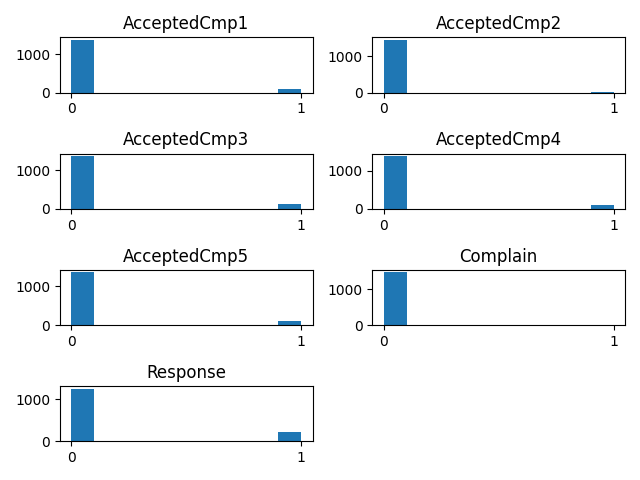

In [38]:
label_columns=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5',
       'Complain', 'Response']
f,a = plt.subplots(4,2)
ii=0
for label in label_columns:
    ir = floor(ii / 2)
    ic = ii % 2
    a[ir,ic].hist(label_df[label])
    a[ir,ic].set_xticks([0,1])
    a[ir,ic].set_title(label)
    ii=ii+1
[f.delaxes(ax) for ax in a.flatten() if not ax.has_data()]
plt.tight_layout()
plt.show()

We can notice that:
- Responses are mostly negative ( which means, not a lot of customers accept the deal)
- The majority of customers carry out not more than 4 purchases with discounts.
- Almost no customer accept the deal at the second campaign.

### Standard Scaler

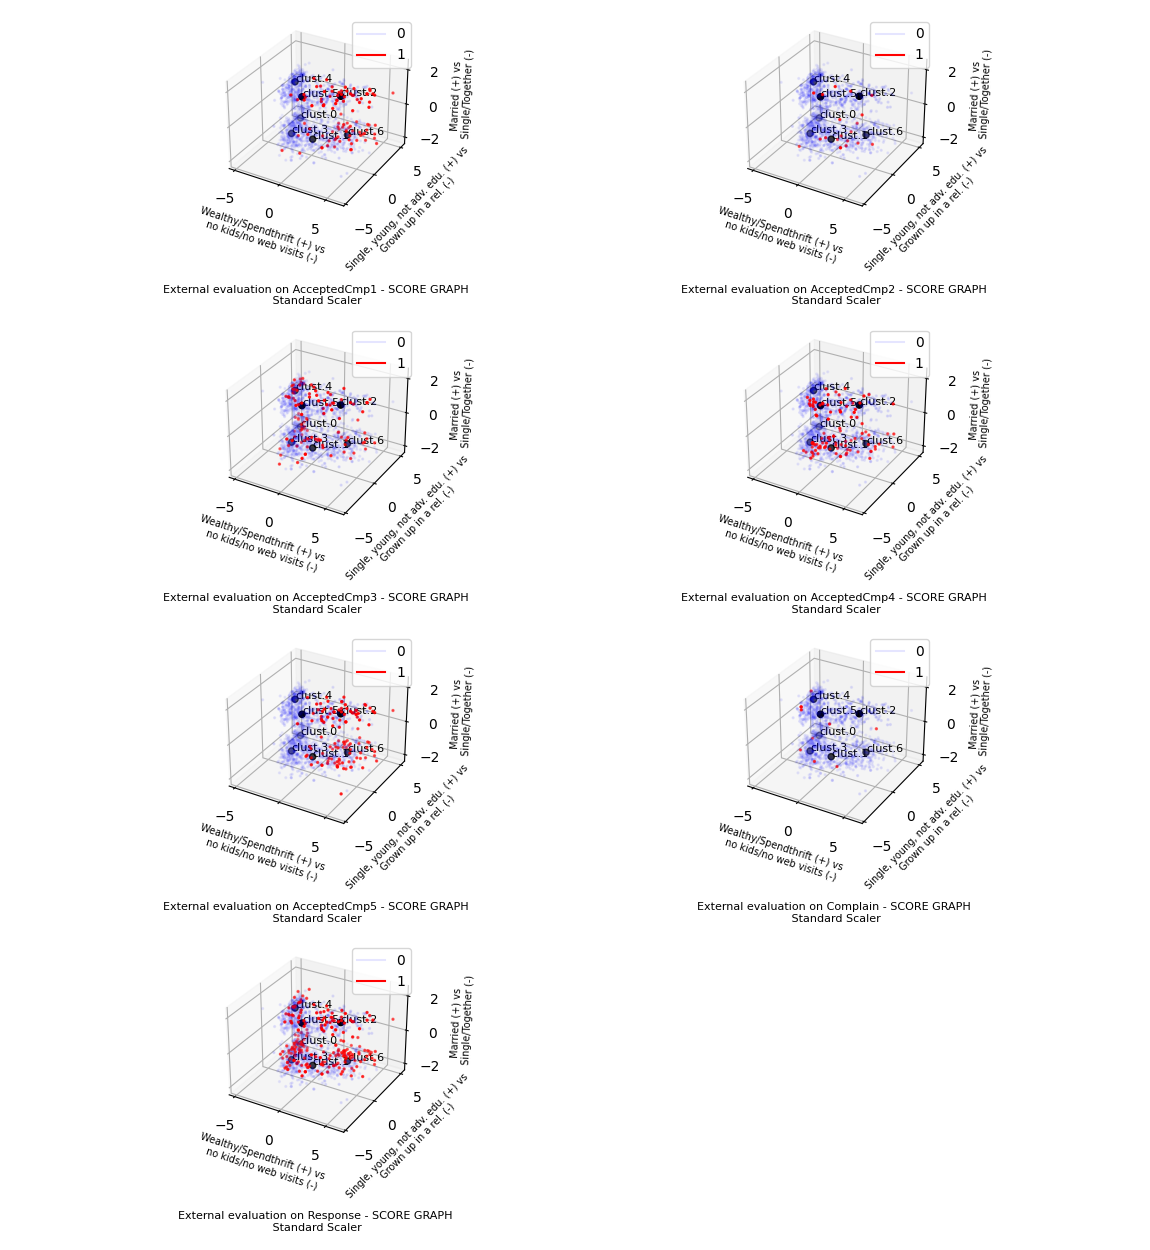

In [39]:

#custom color set to enhance visualization
set1 = [[0, 0, 1,0.10],[1, 0, 0, 1]]
#iterate all labels
ii=0
#f,a = plt.subplots(4,2,figsize=(8, 8))
sg_3d_km = plt.figure(figsize=(11.5, 12.5))
for label in label_columns: 
    ir = floor(ii / 2)
    ic = ii % 2
    values = sorted(label_df[label].unique())
    colors = {values[i]:set1[i] for i in range(len(values))}
    #alpha vector is used to decrease the intensity of the negative response since it would hide the 
    #positive response for each label, information that is much more interesting for us
    alpha_vector=[0.75 if t==1 else 0 for t in label_df[label].values]
    #creation of column that will map each row to the corresponding color for the considered label
    color_attribute_name="color_"+label
    label_df[color_attribute_name] = [colors[t] for t in label_df[label].values]
    colors_legend = [Line2D([0], [0], c=colors[k]) for k in colors.keys()]
    ax_sg_3d_km = sg_3d_km.add_subplot(4,2,ii+1, projection='3d')
    #plot points
    ax_sg_3d_km.scatter(Y_std[:,0],Y_std[:,1],Y_std[:,2],c=label_df[color_attribute_name].values,s=2)
    #plot cluster centers
    ax_sg_3d_km.scatter(km_std.cluster_centers_[:,0],km_std.cluster_centers_[:,1],km_std.cluster_centers_[:,2],c='black')
    #add label to clusters
    for kk in range(k_std):
        ax_sg_3d_km.text(km_std.cluster_centers_[kk, 0], km_std.cluster_centers_[kk, 1], km_std.cluster_centers_[kk, 2], f'clust.{kk}',fontsize=8)
    ax_sg_3d_km.set_title(f"External evaluation on {label} - SCORE GRAPH\n Standard Scaler",fontsize = 8,y=-0.5)
    
    ax_sg_3d_km.set_xlabel(pc_names_std[0],fontsize = 7)
    ax_sg_3d_km.set_ylabel(pc_names_std[1],fontsize = 7)
    ax_sg_3d_km.set_zlabel(pc_names_std[2],fontsize = 7)
    #add legend
    plt.legend(colors_legend, [k for k in colors.keys()])
    plt.grid()
    #plt.tight_layout()
    ii=ii+1
"""
plt.subplots_adjust(left=0.1,
                    bottom=0, 
                    right=0.9, 
                    top=0.9, 
                    )
"""
plt.tight_layout()
plt.show()

We have separated the label 'NumDealsPurchases' since we reckoned the usage of a colorbar to handle more effectively a wider range of values

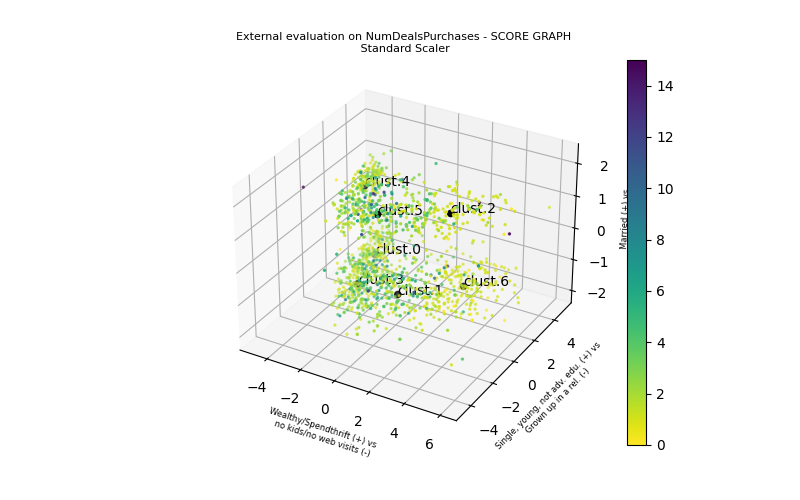

In [40]:
#graph for NumDealsPurchases
sg_3d_km = plt.figure(figsize=(8, 5))
ax_sg_3d_km = sg_3d_km.add_subplot(111, projection='3d')
num_purch=ax_sg_3d_km.scatter(Y_std[:,0],Y_std[:,1],Y_std[:,2],c=label_df['NumDealsPurchases'].values,s=2,cmap="viridis_r")
plt.colorbar(num_purch)
ax_sg_3d_km.scatter(km_std.cluster_centers_[:,0],km_std.cluster_centers_[:,1],km_std.cluster_centers_[:,2],c='black')
for kk in range(k_std):
    ax_sg_3d_km.text(km_std.cluster_centers_[kk, 0], km_std.cluster_centers_[kk, 1], km_std.cluster_centers_[kk, 2], f'clust.{kk}')
plt.title(f"External evaluation on {'NumDealsPurchases'} - SCORE GRAPH\n Standard Scaler",fontsize=8)
ax_sg_3d_km.set_xlabel(pc_names_std[0],fontsize=6)
ax_sg_3d_km.set_ylabel(pc_names_std[1],fontsize=6)
ax_sg_3d_km.set_zlabel(pc_names_std[2],fontsize=6)
plt.grid()
plt.show()

#### Evaluation
From the above plots, we can conclude that:
- Wealthier categories such as clusters 1,2,6 tend to accept both at the first or last campaign. We think this is plausible since a a wealthier category may care less about waiting for the perfect discount. We assume that the main difference between the ones that purchase at the first campaign are more spendthrift, whereas the ones that accept later are more cheap.
- Categories that may be more sensible to expenses ( such as clusters 0,3,4,5) tend to accept at the third campaign. Hipotising that campaigns become more convenient towards the last one, these categories prefer not accept at the first offer because they wait for a more convenient one, but at the same time they dont't want to risk to lose a good offer/ they can't wait because of financial issues.
- In general couples tends to make an higher number of purchases with discounts. This can be due to the fact that a couple may have more expenses than a single person, thus they look for purchases with savings.
- An higher response rate comes from wealthy single customer, which makes sense, since they have less expenses and they can spend more on purchases.


### Min-Max Scaler

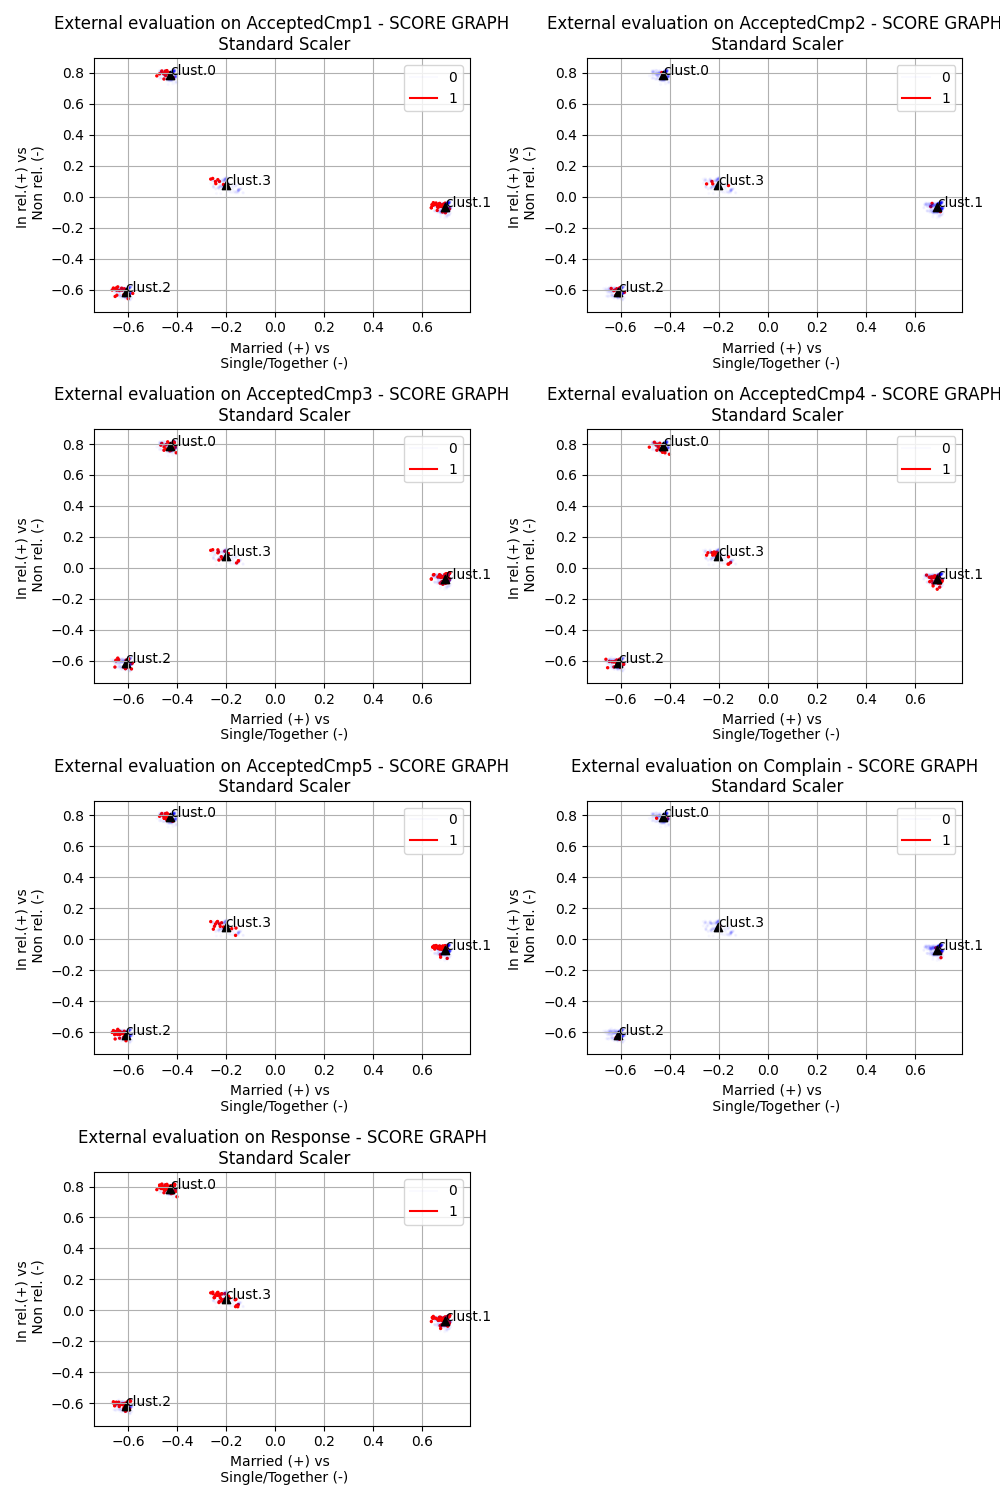

In [41]:
set1 = [[0, 0, 1,0.02],[1, 0, 0, 1]]
f,a = plt.subplots(4,2,figsize=(10, 15))
ii=0
for label in label_columns: 
    ir = floor(ii / 2)
    ic = ii % 2
    values = sorted(label_df[label].unique())
    colors = {values[i]:set1[i] for i in range(len(values))}
    color_attribute_name="color_"+label
    label_df[color_attribute_name] = [colors[t] for t in label_df[label].values]
    colors_legend = [Line2D([0], [0], color=colors[k]) for k in colors.keys()]
    #plt.figure()
    a[ir,ic].scatter(Y_mm[:,0],Y_mm[:,1],c=label_df[color_attribute_name].values,s=2)
    a[ir,ic].scatter(km_mm.cluster_centers_[:, 0], km_mm.cluster_centers_[:, 1], c='black', marker='^')
    for kk in range(k_mm):
        a[ir,ic].text(km_mm.cluster_centers_[kk, 0], km_mm.cluster_centers_[kk, 1], f'clust.{kk}')
    a[ir,ic].set_title(f"External evaluation on {label} - SCORE GRAPH\n Standard Scaler")
    a[ir,ic].set(xlabel=pc_names_mm[0],ylabel=pc_names_mm[1])
    #a[ir,ic].xlabel(pc_names_mm[0])
    #a[ir,ic].ylabel(pc_names_mm[1])
    a[ir,ic].legend(colors_legend, [k for k in colors.keys()])
    a[ir,ic].grid()
    ii=ii+1
[f.delaxes(ax) for ax in a.flatten() if not ax.has_data()]
plt.tight_layout()
plt.show()

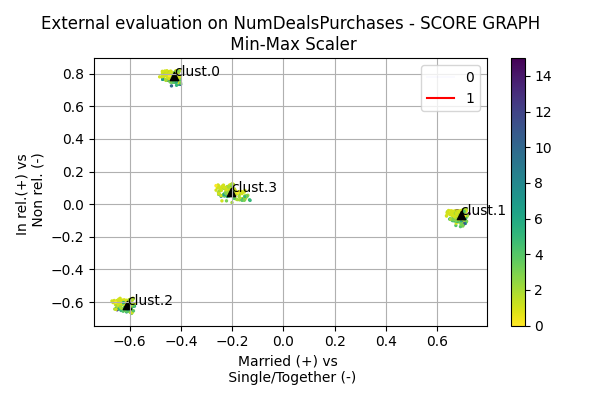

In [42]:
plt.figure(figsize=(6,4))
plot=plt.scatter(Y_mm[:,0],Y_mm[:,1],c=label_df['NumDealsPurchases'].values,s=2, cmap="viridis_r")
plt.scatter(km_mm.cluster_centers_[:, 0], km_mm.cluster_centers_[:, 1], c='black', marker='^')
plt.colorbar(plot)
for kk in range(k_mm):
    plt.text(km_mm.cluster_centers_[kk, 0], km_mm.cluster_centers_[kk, 1], f'clust.{kk}')
plt.title(f"External evaluation on {'NumDealsPurchases'} - SCORE GRAPH\n Min-Max Scaler")
plt.xlabel(pc_names_mm[0])
plt.ylabel(pc_names_mm[1])
plt.legend(colors_legend, [k for k in colors.keys()])
plt.tight_layout()
plt.grid()
plt.show()

#### Evaluation
From the previous graphs, we can depict that:
- engaged and widow/divorced are the ones that tend to accept more often. This may makes sense because of their potential finance fragility ( i.e. the first ones are investing in buying house/furniture and the second ones are alone and potentially old and hence in pension)
- we can't really discriminate a pattern in the criteria for which campaings are accepted.
'0-Engaged','1-Have been married (Widow / Divorced)','2-Single','3-Together
response
cluster 0,1

# Final consideration
The usage of the Standard scaler yielded clusters less definite from the point of view of internal evaluation, however it allowed us to identify an higher number of clusters characterized not only by their relationship status, but also by their financial status and purchases habits.
This has been possible by exploring a space composed by three dimensions.
The external evaluation has also been easier and get more coherent results with the provided labels.

The usage of the Min-Max Scaler yielded cluster really well definite from an internal point of view, however the analysis of the clusters obtained have been more difficult. This is due to the space in which they have been defined. The PCs composing the space where indeed concerning the relationship status of the customers, without providing any insights on the financial situation and purchases habits of the customers. This is due to the fact that the Min-Max Scaler didn't normalise the data and thus the variances of each attributes still had a different magnitude. In particular, we can notice that the variance of features related to the relationships status was higher, thus the PCA may have been influenced to consider these features as more relevant among others. The external evaluation didn't bring any relevant conclusion, because the label provided were mostly concerning the purchase habits of the customers, which can be difficulted to be deduced without any hints of their attitude.

We think that the analysis could be improved by working on the following points:
- By observin the domain of the marital status, we have noticed that some values (i.e. YOLO, Absurd, Alone ) contain just one record. Since marital status is then encoded with One-Hot Encoding, we are basically adding three extra dimensions without adding real extra informations. Hence, we think that more data about this marital status should be collected or they should be removed/merge with another domain value( for example single)
- We have noticed an unbalanced distributions within the features marital_status, age, education. This could compromise the ability of the PCA and clustering to identify relevant features and hence correctly identify  categories that are not sufficiently represented in the dataset.
